RBF and MMDLoss classes are copied from https://github.com/yiftachbeer/mmd_loss_pytorch with some changes
Some inspiration from https://www.kaggle.com/code/onurtunali/maximum-mean-discrepancy
Autoencoder code from https://www.geeksforgeeks.org/implementing-an-autoencoder-in-pytorch/ with changes to add dropout

In [2]:
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as trans

Define RBF kernel and MMD loss functions:

In [3]:
class RBF(nn.Module):

    def __init__(self, bandwidth=None): #bandwidth = sigma
        super().__init__()
        self.bandwidth_multipliers = torch.tensor([0.5, 1, 5, 10, 20, 40], dtype = torch.float32) 
        self.bandwidth = bandwidth

    def get_bandwidth(self): #if we want to scale the bandwiths
        if self.bandwidth is None:
            return 1
        return self.bandwidth

    def forward(self, X): #calculates the RBF kernel between each column in X
        L2_distances = torch.cdist(X, X) ** 2 
        return torch.exp(-0.5 * L2_distances[None, ...] / ((self.get_bandwidth() * self.bandwidth_multipliers)**2)[:, None, None]).sum(dim=0) - 6*torch.eye(len(X), dtype=torch.float32)
        #dim 0 is the bandwidth dimension : the function returns sum of kernels with different bandwiths defined by self.bandwith_multipliers
        #returns 0 on the diagonal line : dont care for kernel between data point and itself

class MMDLoss(nn.Module):

    def __init__(self, kernel=RBF()):
        super().__init__()
        self.kernel = kernel

    def forward(self, X, Y): #calculates the unbiased empirical MMD between X and Y
        K = self.kernel(torch.vstack([X, Y]))

        X_size = X.shape[0]
        Y_size = Y.shape[0]
        XX = K[:X_size, :X_size].sum() / (X_size**2-X_size)
        XY = K[:X_size, X_size:].mean()
        YY = K[X_size:, X_size:].sum() / (Y_size**2-Y_size)
        return XX - 2 * XY + YY

Parameters:

In [4]:
N_batch = 500 #training batch size
N_epochs = 50 #training iterations
N_input = 50 #dimension of uniformly sampled model input

N_batch_AE = 128 #autoencoder training batch size
N_epochs_AE = 32 #autoencoder training iterations

Load MNIST data:

In [5]:
#training data
trainds = torchvision.datasets.MNIST(root='./data', 
                                          train=True, 
                                          transform=trans.ToTensor(),  
                                          download=True)
#training data loader for MMD network
trainldr = torch.utils.data.DataLoader(dataset=trainds, 
                                           batch_size=N_batch, 
                                           shuffle=True)
#training data loader for autoencoder
AE_trainldr = torch.utils.data.DataLoader(dataset=trainds, 
                                           batch_size=N_batch_AE, 
                                           shuffle=True)

Define and train autoencoder:

In [6]:
np.random.seed(123)
torch.manual_seed(123)

class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
         
        # Encoder
        # 784 ==> 9
        self.encoder = torch.nn.Sequential(
            torch.nn.Dropout(0.2),
            torch.nn.Linear(28 * 28, 400),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(400, 200),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(200, 100),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(100, 50),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(50, 10),
            torch.nn.Sigmoid() 
        )
         
        # Decoder
        # 9 ==> 784
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 200),
            torch.nn.ReLU(),
            torch.nn.Linear(200, 400),
            torch.nn.ReLU(),
            torch.nn.Linear(400, 28 * 28),
            torch.nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self,x):
        return self.encoder(x)
    
    def decode(self,enc):
        return self.decoder(enc)
    
autoencoder = AE()

# MSE Loss function
AE_loss_fn = torch.nn.MSELoss()
 
# Adam Optimizer with lr = 0.1
AE_optimizer = torch.optim.Adam(autoencoder.parameters(),
                             lr = 0.001)

#training loop
for epoch in range(N_epochs_AE):
    for idx, (img, lbls) in enumerate(AE_trainldr): 
        img = img.reshape(-1, 28*28) #training data
        
        reconstructed = autoencoder(img) #autoencoder outputs

        loss = AE_loss_fn(img, reconstructed)
        AE_optimizer.zero_grad() #reset gradient
        loss.backward() #backpropagation
        AE_optimizer.step() #optimizer iteration
    print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss 0.056839704513549805
Finished epoch 1, latest loss 0.0550229474902153
Finished epoch 2, latest loss 0.05304902791976929
Finished epoch 3, latest loss 0.04836162179708481
Finished epoch 4, latest loss 0.04849005863070488
Finished epoch 5, latest loss 0.04633515328168869
Finished epoch 6, latest loss 0.04721422865986824
Finished epoch 7, latest loss 0.04352434724569321
Finished epoch 8, latest loss 0.046213556081056595
Finished epoch 9, latest loss 0.043090421706438065
Finished epoch 10, latest loss 0.04163723811507225
Finished epoch 11, latest loss 0.04212384670972824
Finished epoch 12, latest loss 0.041304316371679306
Finished epoch 13, latest loss 0.042114805430173874
Finished epoch 14, latest loss 0.04175011068582535
Finished epoch 15, latest loss 0.03966350480914116
Finished epoch 16, latest loss 0.04131152108311653
Finished epoch 17, latest loss 0.03882499784231186
Finished epoch 18, latest loss 0.038030873984098434
Finished epoch 19, latest loss 0.040

Autoencoder output:

5


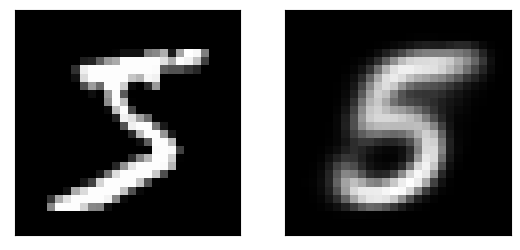

In [7]:
plt.gray()

#first training image:
ax = plt.subplot(1, 2, 1)
(img_data, lbl) = trainds[0]
img_data = img_data.reshape(28, 28)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.imshow(img_data)
print(lbl)

#output of autoencoder:
ax = plt.subplot(1, 2, 2)
img_reshaped = img_data.reshape(1,-1)
img_reconstructed = autoencoder(img_reshaped)
img_reconstructed = img_reconstructed.reshape(28,28)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.imshow(img_reconstructed.detach())

Define the MMD network:

In [8]:
class network(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(N_input, 200)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(200, 100)
        self.act2 = nn.ReLU()
        self.hidden3 = nn.Linear(100, 100)
        self.act3 = nn.ReLU()
        self.hidden4 = nn.Linear(100, 200)
        self.act4 = nn.ReLU()
        self.output = nn.Linear(200, 10)
        self.act_output = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.act3(self.hidden3(x))
        x = self.act4(self.hidden4(x))
        x = self.act_output(self.output(x))
        return x
    
model = network()

loss_fn = MMDLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

Train MMD netowrk:

In [9]:
np.random.seed(903)
torch.manual_seed(903)

#training loop
for epoch in range(N_epochs):
    for idx, (x, lbls) in enumerate(trainldr):
        x = x.reshape(-1, 28*28) 
        x = autoencoder.encode(x) #real data (in feature space)

        x_input = np.random.uniform(-0.5,0.5,N_batch*N_input)
        x_input = torch.tensor(x_input, dtype=torch.float32).reshape(N_batch, N_input) #model inputs

        x_output = model(x_input) #generated data (in feature space)

        loss = loss_fn(x, x_output)
        optimizer.zero_grad() #reset gradient
        loss.backward() #backpropagation
        optimizer.step() #optimizer iteration
    print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss 0.09027576446533203
Finished epoch 1, latest loss 0.056578636169433594
Finished epoch 2, latest loss 0.041182518005371094
Finished epoch 3, latest loss 0.012941837310791016
Finished epoch 4, latest loss 0.027240276336669922
Finished epoch 5, latest loss 0.010041236877441406
Finished epoch 6, latest loss 0.006427764892578125
Finished epoch 7, latest loss 0.009685039520263672
Finished epoch 8, latest loss 0.005488395690917969
Finished epoch 9, latest loss 0.008006572723388672
Finished epoch 10, latest loss 0.004139423370361328
Finished epoch 11, latest loss 0.006170749664306641
Finished epoch 12, latest loss 0.0010142326354980469
Finished epoch 13, latest loss 0.0014929771423339844
Finished epoch 14, latest loss 0.0026988983154296875
Finished epoch 15, latest loss 0.00162506103515625
Finished epoch 16, latest loss -0.0006351470947265625
Finished epoch 17, latest loss 0.0034432411193847656
Finished epoch 18, latest loss 0.002810955047607422
Finished epoch 19,

Visualize model outputs:

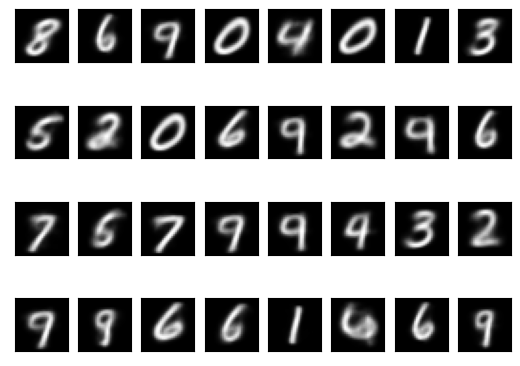

In [10]:
np.random.seed(0)

noises = [] #store for next code cell
plt.gray()
for r in range(4):
  for c in range(8):
    ax = plt.subplot(4, 8, r * 8 + c + 1)
    noise = np.random.uniform(-0.5,0.5,N_input)
    noise = torch.tensor(noise, dtype=torch.float32).reshape(1,-1) #random model inputs
    with torch.no_grad(): #do not update gradient
      test = model(noise)
    image = autoencoder.decode(test)
    plt.imshow(image.detach().squeeze().cpu().reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    noises.append(noise)
plt.show()

Plot nearest neighbours:

tensor([[0.0852]], grad_fn=<CdistBackward0>)
tensor([[0.0683]], grad_fn=<CdistBackward0>)
tensor([[0.0253]], grad_fn=<CdistBackward0>)
tensor([[0.0415]], grad_fn=<CdistBackward0>)


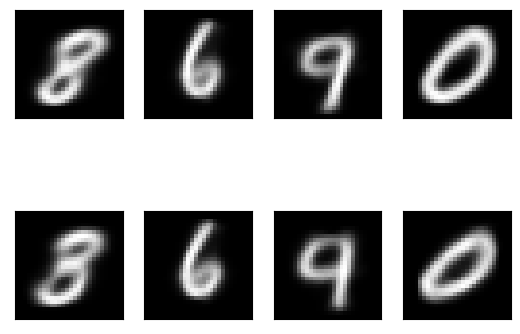

In [11]:
for i in range(4): #first four images from previous test data
    ax = plt.subplot(2, 4, i+1)
    with torch.no_grad():
        test = model(noises[i])
    image = autoencoder.decode(test)
    plt.imshow(image.detach().squeeze().cpu().reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    smallest = 0 #index such that euclidean distance between image and train image is smallest
    dist = float('inf') #smallest distance
    #search for nearest neighbour in feature space of training data:
    for j in range(len(trainds)):
        train = autoencoder.encode(trainds[j][0].reshape(-1,28*28))
        dist_new = torch.cdist(test,train)
        if dist_new < dist: 
            dist = dist_new
            smallest = j
    ax = plt.subplot(2, 4, 5+i)
    image = autoencoder(trainds[smallest][0].reshape(-1, 28*28))
    plt.imshow(image.detach().squeeze().cpu().reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    print(dist)
plt.show()